In [1]:
import torch
from torch import nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.nn.utils import weight_norm
import numpy as np
device=torch.device('cuda:0')
from copy import deepcopy
import matplotlib.pyplot as plt
from scipy.integrate import odeint
import heapq

In [5]:
def arrange_input(data, context):
    assert context >= 1 and isinstance(context, int)
    input = torch.zeros(len(data) - context, context, data.shape[1],
                        dtype=torch.float32, device=data.device)
    target = torch.zeros(len(data) - context, context, data.shape[1],
                         dtype=torch.float32, device=data.device)
    for i in range(context):
        start = i
        end = len(data) - context + i
        input[:, i, :] = data[start:end]
        target[:, i, :] = data[start+1:end+1]
    return input.detach(), target.detach()

In [6]:
def get_weights_copy(model):
    weights_path = 'weights_temp.pt'
    torch.save(model.state_dict(), weights_path)
    return torch.load(weights_path)

In [7]:
def make_var_stationary(beta, radius=0.97):

    p = beta.shape[0]
    lag = beta.shape[1] // p
    bottom = np.hstack((np.eye(p * (lag - 1)), np.zeros((p * (lag - 1), p))))
    beta_tilde = np.vstack((beta, bottom))
    eigvals = np.linalg.eigvals(beta_tilde)
    max_eig = max(np.abs(eigvals))
    nonstationary = max_eig > radius
    if nonstationary:
        return make_var_stationary(0.95 * beta, radius)
    else:
        return beta

def simulate_var(p, T, lag, sparsity=0.2, beta_value=1.0, sd=0.1, seed=0):
    if seed is not None:
        np.random.seed(seed)

    GC = np.eye(p, dtype=int)
    beta = np.eye(p) * beta_value

    num_nonzero = int(p * sparsity) - 1
    for i in range(p):
        choice = np.random.choice(p - 1, size=num_nonzero, replace=False)
        choice[choice >= i] += 1
        beta[i, choice] = beta_value
        GC[i, choice] = 1

    beta = np.hstack([beta for _ in range(lag)])
    beta = make_var_stationary(beta)

    burn_in = 100
    errors = np.random.normal(scale=sd, size=(p, T + burn_in))
    X = np.zeros((p, T + burn_in))
    X[:, :lag] = errors[:, :lag]
    for t in range(lag, T + burn_in):
        X[:, t] = np.dot(beta, X[:, (t-lag):t].flatten(order='F'))
        X[:, t] += + errors[:, t-1]

    return X.T[burn_in:], beta, GC


In [8]:
#model is hidden until the article been published

In [9]:
class ADDSTCN(nn.Module):
    def __init__(self, input_size, num_levels, kernel_size = 2, cuda=1, dilation_c=2):
        super(ADDSTCN, self).__init__()

        self.dwn = DepthwiseNet(input_size, num_levels, kernel_size=kernel_size, dilation_c=dilation_c)
        self.pointwise = nn.Conv1d(input_size, 1, 1)

    def init_weights(self):
        self.pointwise.weight.data.normal_(0, 0.1)

    def forward(self, x):
        x = x.transpose(2, 1)
        y1=self.dwn(x)
        y1 = self.pointwise(y1)
        return y1.transpose(1,2)

In [10]:
class cADDSTCN(nn.Module):
    def __init__(self, num_series, hidden, nonlinearity='relu'):
        super(cADDSTCN, self).__init__()
        self.p = num_series
        self.hidden = hidden

        # Set up networks.
        self.networks = nn.ModuleList([
            ADDSTCN(num_series, hidden) for _ in range(num_series)])

    def forward(self, X):
        return torch.cat([network(X) for network in self.networks], dim=2)

    def GC(self, threshold=True):
        GC = [torch.norm(net.dwn.network[0].conv1.weight, dim=(0,2))
              for net in self.networks]
        GC = torch.stack(GC)
        if threshold:
            return (GC > 0).int()
        else:
            return GC


In [11]:
def prox_update(network, lam, lr): #ISTA hidden until the article been published

In [12]:
def regularize(network, lam):#Lasso
    W = network.dwn.network[0].conv1.weight
    return lam * torch.sum(torch.norm(W, dim=(0,2)))

In [13]:
def ridge_regularize(networks, lam, hidden):#weight decay
    if hidden > 2:
      L2 = lam * (
        torch.sum(torch.stack([networks.dwn.network[i].conv1.weight ** 2 for i in range(1,hidden)])) +
        torch.sum(networks.pointwise.weight ** 2))
    elif hidden == 2:
      L2 = lam * (
        torch.sum(networks.dwn.network[1].conv1.weight ** 2 )+
        torch.sum(networks.pointwise.weight ** 2))
    else:
      L2 = lam * (
        torch.sum(networks.pointwise.weight ** 2))
    return L2

In [14]:
def restore_parameters(model, best_model):
    for params, best_params in zip(model.parameters(), best_model.parameters()):
        params.data = best_params

In [15]:
def train_model_ista(cADDSTCN, X, context, lr, max_iter, lam=0, lam_ridge=0, hidden=0,
                     lookback=5, check_every=50, verbose=1):
    p = X.shape[-1]
    loss_fn = nn.MSELoss(reduction='mean')
    train_loss_list = []
    best_it = None
    best_loss = np.inf
    best_model = None
    loss = sum([loss_fn(cADDSTCN.networks[i](X[:, :-1]), X[:, 1:, i:i+1])
                    for i in range(p)])
    ridge = sum([ridge_regularize(net, lam_ridge,hidden) for net in cADDSTCN.networks])
    smooth = loss + ridge

#Training hidden until the article been published

    return train_loss_list


In [16]:
# Simulate data
X_np, beta, GC = simulate_var(p=10, T=1000, lag=3)
X = torch.tensor(X_np[np.newaxis], dtype=torch.float32, device=device)

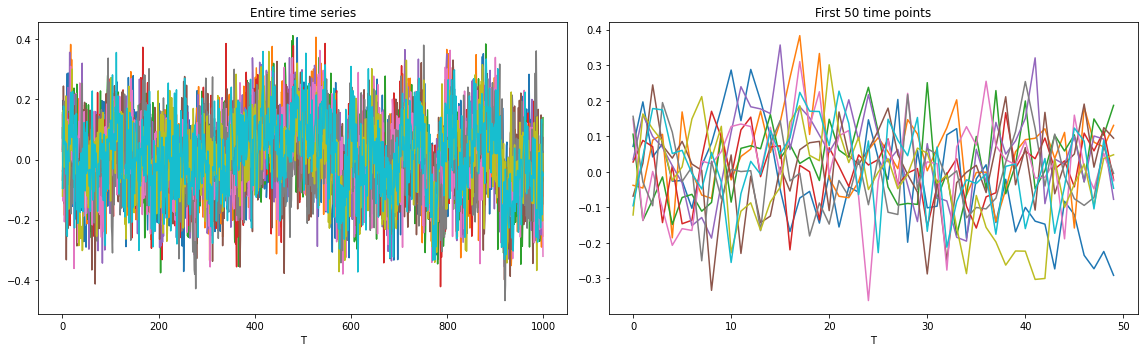

In [17]:
# Plot data
fig, axarr = plt.subplots(1, 2, figsize=(16, 5))
axarr[0].plot(X_np)
axarr[0].set_xlabel('T')
axarr[0].set_title('Entire time series')
axarr[1].plot(X_np[:50])
axarr[1].set_xlabel('T')
axarr[1].set_title('First 50 time points')
plt.tight_layout()
plt.show()

In [18]:
# Set up model
cTCN = cADDSTCN(X.shape[-1], hidden=2).cuda(device=device)

In [19]:
train_loss_list = train_model_ista(
    cTCN, X, context=10, lam=0.006, lam_ridge=1.65e-3, hidden =2, lr=5e-2, max_iter=50000,
    check_every=100)

----------Iter = 100----------
Loss = 0.045044
Variable usage = 100.00%
----------Iter = 200----------
Loss = 0.040839
Variable usage = 100.00%
----------Iter = 300----------
Loss = 0.037193
Variable usage = 100.00%
----------Iter = 400----------
Loss = 0.033990
Variable usage = 100.00%
----------Iter = 500----------
Loss = 0.031179
Variable usage = 100.00%
----------Iter = 600----------
Loss = 0.028757
Variable usage = 100.00%
----------Iter = 700----------
Loss = 0.026711
Variable usage = 100.00%
----------Iter = 800----------
Loss = 0.024967
Variable usage = 97.00%
----------Iter = 900----------
Loss = 0.023433
Variable usage = 94.00%
----------Iter = 1000----------
Loss = 0.022146
Variable usage = 86.00%
----------Iter = 1100----------
Loss = 0.021140
Variable usage = 73.00%
----------Iter = 1200----------
Loss = 0.020383
Variable usage = 63.00%
----------Iter = 1300----------
Loss = 0.019829
Variable usage = 47.00%
----------Iter = 1400----------
Loss = 0.019407
Variable usage = 4

----------Iter = 11500----------
Loss = 0.014969
Variable usage = 20.00%
----------Iter = 11600----------
Loss = 0.014963
Variable usage = 20.00%
----------Iter = 11700----------
Loss = 0.014957
Variable usage = 20.00%
----------Iter = 11800----------
Loss = 0.014950
Variable usage = 20.00%
----------Iter = 11900----------
Loss = 0.014944
Variable usage = 20.00%
----------Iter = 12000----------
Loss = 0.014939
Variable usage = 20.00%
----------Iter = 12100----------
Loss = 0.014933
Variable usage = 20.00%
----------Iter = 12200----------
Loss = 0.014927
Variable usage = 20.00%
----------Iter = 12300----------
Loss = 0.014922
Variable usage = 20.00%
----------Iter = 12400----------
Loss = 0.014916
Variable usage = 20.00%
----------Iter = 12500----------
Loss = 0.014911
Variable usage = 20.00%
----------Iter = 12600----------
Loss = 0.014905
Variable usage = 20.00%
----------Iter = 12700----------
Loss = 0.014900
Variable usage = 20.00%
----------Iter = 12800----------
Loss = 0.014895
Va

----------Iter = 22800----------
Loss = 0.014650
Variable usage = 20.00%
----------Iter = 22900----------
Loss = 0.014649
Variable usage = 20.00%
----------Iter = 23000----------
Loss = 0.014648
Variable usage = 20.00%
----------Iter = 23100----------
Loss = 0.014647
Variable usage = 20.00%
----------Iter = 23200----------
Loss = 0.014646
Variable usage = 20.00%
----------Iter = 23300----------
Loss = 0.014645
Variable usage = 20.00%
----------Iter = 23400----------
Loss = 0.014644
Variable usage = 20.00%
----------Iter = 23500----------
Loss = 0.014643
Variable usage = 20.00%
----------Iter = 23600----------
Loss = 0.014642
Variable usage = 20.00%
----------Iter = 23700----------
Loss = 0.014641
Variable usage = 20.00%
----------Iter = 23800----------
Loss = 0.014640
Variable usage = 20.00%
----------Iter = 23900----------
Loss = 0.014639
Variable usage = 20.00%
----------Iter = 24000----------
Loss = 0.014638
Variable usage = 20.00%
----------Iter = 24100----------
Loss = 0.014637
Va

----------Iter = 34100----------
Loss = 0.014582
Variable usage = 20.00%
----------Iter = 34200----------
Loss = 0.014582
Variable usage = 20.00%
----------Iter = 34300----------
Loss = 0.014582
Variable usage = 20.00%
----------Iter = 34400----------
Loss = 0.014582
Variable usage = 20.00%
----------Iter = 34500----------
Loss = 0.014581
Variable usage = 20.00%
----------Iter = 34600----------
Loss = 0.014581
Variable usage = 20.00%
----------Iter = 34700----------
Loss = 0.014581
Variable usage = 20.00%
----------Iter = 34800----------
Loss = 0.014580
Variable usage = 20.00%
----------Iter = 34900----------
Loss = 0.014580
Variable usage = 20.00%
----------Iter = 35000----------
Loss = 0.014580
Variable usage = 20.00%
----------Iter = 35100----------
Loss = 0.014579
Variable usage = 20.00%
----------Iter = 35200----------
Loss = 0.014579
Variable usage = 20.00%
----------Iter = 35300----------
Loss = 0.014579
Variable usage = 20.00%
----------Iter = 35400----------
Loss = 0.014579
Va

----------Iter = 45400----------
Loss = 0.014560
Variable usage = 20.00%
----------Iter = 45500----------
Loss = 0.014559
Variable usage = 20.00%
----------Iter = 45600----------
Loss = 0.014559
Variable usage = 20.00%
----------Iter = 45700----------
Loss = 0.014559
Variable usage = 20.00%
----------Iter = 45800----------
Loss = 0.014559
Variable usage = 20.00%
----------Iter = 45900----------
Loss = 0.014559
Variable usage = 20.00%
----------Iter = 46000----------
Loss = 0.014559
Variable usage = 20.00%
----------Iter = 46100----------
Loss = 0.014559
Variable usage = 20.00%
----------Iter = 46200----------
Loss = 0.014559
Variable usage = 20.00%
----------Iter = 46300----------
Loss = 0.014558
Variable usage = 20.00%
----------Iter = 46400----------
Loss = 0.014558
Variable usage = 20.00%
----------Iter = 46500----------
Loss = 0.014558
Variable usage = 20.00%
----------Iter = 46600----------
Loss = 0.014558
Variable usage = 20.00%
----------Iter = 46700----------
Loss = 0.014558
Va

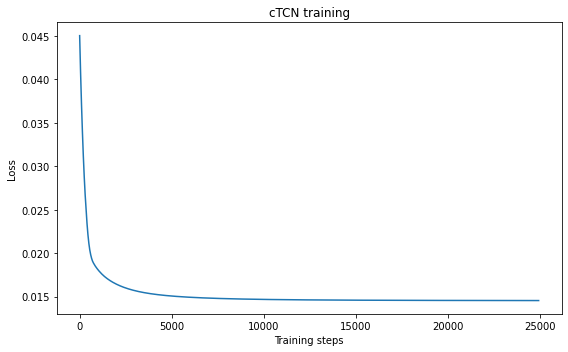

In [20]:
plt.figure(figsize=(8, 5))
train_loss_list_cpu = [tensor.cpu() for tensor in train_loss_list]

# 将train_loss_list_cpu转换为NumPy数组
train_loss_array = np.array([tensor.numpy() for tensor in train_loss_list_cpu])

plt.plot(50 * np.arange(len(train_loss_array)), train_loss_array)
plt.title('cTCN training')
plt.ylabel('Loss')
plt.xlabel('Training steps')
plt.tight_layout()
plt.show()

True variable usage = 20.00%
Estimated variable usage = 20.00%
Accuracy = 100.00%


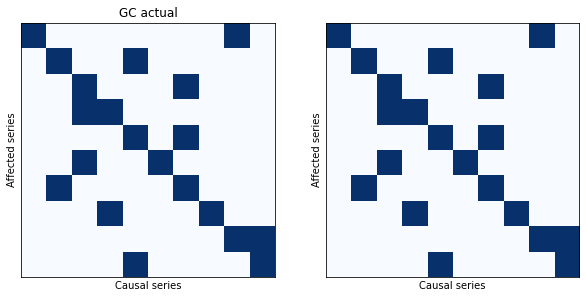

In [21]:
# Verify learned Granger causality
GC_est = cTCN.GC().cpu().data.numpy()

print('True variable usage = %.2f%%' % (100 * np.mean(GC)))
print('Estimated variable usage = %.2f%%' % (100 * np.mean(GC_est)))
print('Accuracy = %.2f%%' % (100 * np.mean(GC == GC_est)))

# Make figures
fig, axarr = plt.subplots(1, 2, figsize=(10, 5))
axarr[0].imshow(GC, cmap='Blues')
axarr[0].set_title('GC actual')
axarr[0].set_ylabel('Affected series')
axarr[0].set_xlabel('Causal series')
axarr[0].set_xticks([])
axarr[0].set_yticks([])

axarr[1].imshow(GC_est, cmap='Blues', vmin=0, vmax=1, extent=(0, len(GC_est), len(GC_est), 0))
axarr[1].set_ylabel('Affected series')
axarr[1].set_xlabel('Causal series')
axarr[1].set_xticks([])
axarr[1].set_yticks([])

# Mark disagreements
for i in range(len(GC_est)):
    for j in range(len(GC_est)):
        if GC[i, j] != GC_est[i, j]:
            rect = plt.Rectangle((j, i-0.05), 1, 1, facecolor='none', edgecolor='red', linewidth=1)
            axarr[1].add_patch(rect)

plt.show()

----------Iter = 100----------
Loss = 0.021217
Variable usage = 100.00%
----------Iter = 200----------
Loss = 0.020119
Variable usage = 100.00%
----------Iter = 300----------
Loss = 0.019244
Variable usage = 100.00%
----------Iter = 400----------
Loss = 0.018536
Variable usage = 100.00%
----------Iter = 500----------
Loss = 0.017962
Variable usage = 100.00%
----------Iter = 600----------
Loss = 0.017496
Variable usage = 100.00%
----------Iter = 700----------
Loss = 0.017108
Variable usage = 100.00%
----------Iter = 800----------
Loss = 0.016773
Variable usage = 100.00%
----------Iter = 900----------
Loss = 0.016475
Variable usage = 100.00%
----------Iter = 1000----------
Loss = 0.016204
Variable usage = 100.00%
----------Iter = 1100----------
Loss = 0.015957
Variable usage = 100.00%
----------Iter = 1200----------
Loss = 0.015728
Variable usage = 100.00%
----------Iter = 1300----------
Loss = 0.015516
Variable usage = 100.00%
----------Iter = 1400----------
Loss = 0.015319
Variable usa

----------Iter = 1400----------
Loss = 0.015824
Variable usage = 100.00%
----------Iter = 1500----------
Loss = 0.015632
Variable usage = 100.00%
----------Iter = 1600----------
Loss = 0.015453
Variable usage = 100.00%
----------Iter = 1700----------
Loss = 0.015285
Variable usage = 100.00%
----------Iter = 1800----------
Loss = 0.015127
Variable usage = 100.00%
----------Iter = 1900----------
Loss = 0.014978
Variable usage = 100.00%
----------Iter = 2000----------
Loss = 0.014838
Variable usage = 100.00%
----------Iter = 2100----------
Loss = 0.014704
Variable usage = 100.00%
----------Iter = 2200----------
Loss = 0.014577
Variable usage = 100.00%
----------Iter = 2300----------
Loss = 0.014456
Variable usage = 100.00%
----------Iter = 2400----------
Loss = 0.014342
Variable usage = 100.00%
----------Iter = 2500----------
Loss = 0.014234
Variable usage = 100.00%
----------Iter = 2600----------
Loss = 0.014130
Variable usage = 100.00%
----------Iter = 2700----------
Loss = 0.014031
Var

----------Iter = 2700----------
Loss = 0.014801
Variable usage = 100.00%
----------Iter = 2800----------
Loss = 0.014700
Variable usage = 100.00%
----------Iter = 2900----------
Loss = 0.014604
Variable usage = 100.00%
----------Iter = 3000----------
Loss = 0.014511
Variable usage = 100.00%
----------Iter = 3100----------
Loss = 0.014421
Variable usage = 100.00%
----------Iter = 3200----------
Loss = 0.014335
Variable usage = 100.00%
----------Iter = 3300----------
Loss = 0.014252
Variable usage = 100.00%
----------Iter = 3400----------
Loss = 0.014172
Variable usage = 100.00%
----------Iter = 3500----------
Loss = 0.014094
Variable usage = 100.00%
----------Iter = 3600----------
Loss = 0.014020
Variable usage = 100.00%
----------Iter = 3700----------
Loss = 0.013948
Variable usage = 100.00%
----------Iter = 3800----------
Loss = 0.013878
Variable usage = 100.00%
----------Iter = 3900----------
Loss = 0.013810
Variable usage = 100.00%
----------Iter = 4000----------
Loss = 0.013745
Var

----------Iter = 4000----------
Loss = 0.014400
Variable usage = 100.00%
----------Iter = 4100----------
Loss = 0.014314
Variable usage = 100.00%
----------Iter = 4200----------
Loss = 0.014230
Variable usage = 100.00%
----------Iter = 4300----------
Loss = 0.014149
Variable usage = 100.00%
----------Iter = 4400----------
Loss = 0.014071
Variable usage = 100.00%
----------Iter = 4500----------
Loss = 0.013995
Variable usage = 100.00%
----------Iter = 4600----------
Loss = 0.013921
Variable usage = 100.00%
----------Iter = 4700----------
Loss = 0.013850
Variable usage = 100.00%
----------Iter = 4800----------
Loss = 0.013781
Variable usage = 100.00%
----------Iter = 4900----------
Loss = 0.013713
Variable usage = 100.00%
----------Iter = 5000----------
Loss = 0.013648
Variable usage = 100.00%
----------Iter = 100----------
Loss = 0.025751
Variable usage = 100.00%
----------Iter = 200----------
Loss = 0.024461
Variable usage = 100.00%
----------Iter = 300----------
Loss = 0.023556
Variab

----------Iter = 400----------
Loss = 0.027081
Variable usage = 100.00%
----------Iter = 500----------
Loss = 0.026068
Variable usage = 100.00%
----------Iter = 600----------
Loss = 0.025156
Variable usage = 100.00%
----------Iter = 700----------
Loss = 0.024325
Variable usage = 100.00%
----------Iter = 800----------
Loss = 0.023565
Variable usage = 100.00%
----------Iter = 900----------
Loss = 0.022864
Variable usage = 100.00%
----------Iter = 1000----------
Loss = 0.022213
Variable usage = 100.00%
----------Iter = 1100----------
Loss = 0.021606
Variable usage = 100.00%
----------Iter = 1200----------
Loss = 0.021040
Variable usage = 100.00%
----------Iter = 1300----------
Loss = 0.020512
Variable usage = 100.00%
----------Iter = 1400----------
Loss = 0.020019
Variable usage = 100.00%
----------Iter = 1500----------
Loss = 0.019564
Variable usage = 99.00%
----------Iter = 1600----------
Loss = 0.019142
Variable usage = 98.00%
----------Iter = 1700----------
Loss = 0.018744
Variable us

----------Iter = 1800----------
Loss = 0.018156
Variable usage = 33.00%
----------Iter = 1900----------
Loss = 0.017996
Variable usage = 30.00%
----------Iter = 2000----------
Loss = 0.017852
Variable usage = 29.00%
----------Iter = 2100----------
Loss = 0.017718
Variable usage = 27.00%
----------Iter = 2200----------
Loss = 0.017595
Variable usage = 26.00%
----------Iter = 2300----------
Loss = 0.017480
Variable usage = 25.00%
----------Iter = 2400----------
Loss = 0.017372
Variable usage = 25.00%
----------Iter = 2500----------
Loss = 0.017271
Variable usage = 24.00%
----------Iter = 2600----------
Loss = 0.017174
Variable usage = 23.00%
----------Iter = 2700----------
Loss = 0.017083
Variable usage = 23.00%
----------Iter = 2800----------
Loss = 0.016996
Variable usage = 23.00%
----------Iter = 2900----------
Loss = 0.016913
Variable usage = 22.00%
----------Iter = 3000----------
Loss = 0.016833
Variable usage = 22.00%
----------Iter = 3100----------
Loss = 0.016757
Variable usage =

----------Iter = 3300----------
Loss = 0.018115
Variable usage = 0.00%
----------Iter = 3400----------
Loss = 0.018044
Variable usage = 0.00%
----------Iter = 3500----------
Loss = 0.017976
Variable usage = 0.00%
----------Iter = 3600----------
Loss = 0.017910
Variable usage = 0.00%
----------Iter = 3700----------
Loss = 0.017847
Variable usage = 0.00%
----------Iter = 3800----------
Loss = 0.017785
Variable usage = 0.00%
----------Iter = 3900----------
Loss = 0.017725
Variable usage = 0.00%
----------Iter = 4000----------
Loss = 0.017668
Variable usage = 0.00%
----------Iter = 4100----------
Loss = 0.017612
Variable usage = 0.00%
----------Iter = 4200----------
Loss = 0.017558
Variable usage = 0.00%
----------Iter = 4300----------
Loss = 0.017506
Variable usage = 0.00%
----------Iter = 4400----------
Loss = 0.017455
Variable usage = 0.00%
----------Iter = 4500----------
Loss = 0.017406
Variable usage = 0.00%
----------Iter = 4600----------
Loss = 0.017359
Variable usage = 0.00%
------

----------Iter = 4900----------
Loss = 0.017152
Variable usage = 0.00%
----------Iter = 5000----------
Loss = 0.017113
Variable usage = 0.00%
----------Iter = 100----------
Loss = 0.085731
Variable usage = 100.00%
----------Iter = 200----------
Loss = 0.033283
Variable usage = 54.00%
----------Iter = 300----------
Loss = 0.022005
Variable usage = 2.00%
----------Iter = 400----------
Loss = 0.021358
Variable usage = 0.00%
----------Iter = 500----------
Loss = 0.021182
Variable usage = 0.00%
----------Iter = 600----------
Loss = 0.021012
Variable usage = 0.00%
----------Iter = 700----------
Loss = 0.020847
Variable usage = 0.00%
----------Iter = 800----------
Loss = 0.020688
Variable usage = 0.00%
----------Iter = 900----------
Loss = 0.020534
Variable usage = 0.00%
----------Iter = 1000----------
Loss = 0.020385
Variable usage = 0.00%
----------Iter = 1100----------
Loss = 0.020241
Variable usage = 0.00%
----------Iter = 1200----------
Loss = 0.020101
Variable usage = 0.00%
----------It

----------Iter = 1500----------
Loss = 0.019652
Variable usage = 0.00%
----------Iter = 1600----------
Loss = 0.019532
Variable usage = 0.00%
----------Iter = 1700----------
Loss = 0.019415
Variable usage = 0.00%
----------Iter = 1800----------
Loss = 0.019303
Variable usage = 0.00%
----------Iter = 1900----------
Loss = 0.019193
Variable usage = 0.00%
----------Iter = 2000----------
Loss = 0.019088
Variable usage = 0.00%
----------Iter = 2100----------
Loss = 0.018986
Variable usage = 0.00%
----------Iter = 2200----------
Loss = 0.018887
Variable usage = 0.00%
----------Iter = 2300----------
Loss = 0.018791
Variable usage = 0.00%
----------Iter = 2400----------
Loss = 0.018699
Variable usage = 0.00%
----------Iter = 2500----------
Loss = 0.018609
Variable usage = 0.00%
----------Iter = 2600----------
Loss = 0.018523
Variable usage = 0.00%
----------Iter = 2700----------
Loss = 0.018439
Variable usage = 0.00%
----------Iter = 2800----------
Loss = 0.018358
Variable usage = 0.00%
------

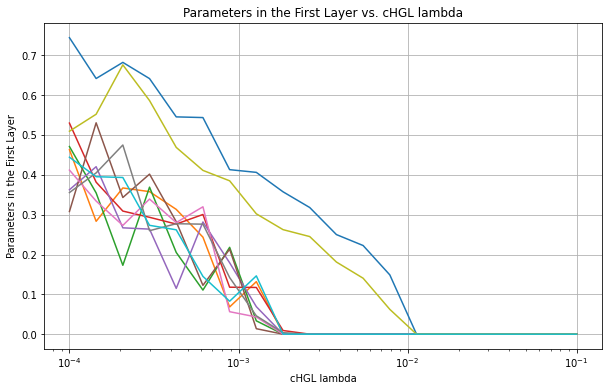

In [23]:
l1_alphas = np.logspace(-4, -1, 20)

layer1_params = []

for alpha in l1_alphas:

    cTCN = cADDSTCN(X.shape[-1], hidden=2).cuda(device=device)
    train_loss_list = train_model_ista(
    cTCN, X, context=10, lam=alpha, lam_ridge=1.65e-3, hidden =2, lr=5e-2, max_iter=5000,
    check_every=100)

    layer1_params.append(cTCN.GC(threshold = 0).cpu().data.numpy()[0,:])

layer1_p = np.vstack(layer1_params)
plt.figure(figsize=(10, 6))

plt.semilogx(l1_alphas, layer1_p[:,0])
plt.semilogx(l1_alphas, layer1_p[:,1])
plt.semilogx(l1_alphas, layer1_p[:,2])
plt.semilogx(l1_alphas, layer1_p[:,3])
plt.semilogx(l1_alphas, layer1_p[:,4])
plt.semilogx(l1_alphas, layer1_p[:,5])
plt.semilogx(l1_alphas, layer1_p[:,6])
plt.semilogx(l1_alphas, layer1_p[:,7])
plt.semilogx(l1_alphas, layer1_p[:,8])
plt.semilogx(l1_alphas, layer1_p[:,9])
plt.xlabel('cHGL lambda')
plt.ylabel('Parameters in the First Layer')
plt.title('Parameters in the First Layer vs. cHGL lambda')
plt.grid(True)
plt.show()